In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import notebook as tqdm_notebook
import pandas as pd


from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [2]:
def subtract_offset(forward_work, reverse_work):

    print("--> subtracting offset")
    
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    return forward_work_offset, reverse_work_offset


def analyse(forward_accumulated, reverse_accumulated):
    
    print("--> computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    return dg, ddg


def plot_works(forward_work_offset,
               reverse_work_offset,
               dg,
               ddg,
               phase,
               mutation,
               title,
               save=False,
               output_dir=None):
    
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    
    # Plot work trajectories
    # TODO: automatically determine the x axis -> this is a bit of a hack at the moment
    print("--> plotting work trajs")
    
    for i, cycle in enumerate(forward_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[0], label='forward')
        else:
            plt.plot(x, y, color=CB_color_cycle[0])
        
    for i, cycle in enumerate(reverse_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = -cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[1], label='reverse')
        else:
            plt.plot(x, y, color=CB_color_cycle[1])
        
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_traj.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_traj.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()
    
    # Plot work distributions
    print("--> plotting work distrib")
    
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward, color=CB_color_cycle[0], label='forward')
    sns.distplot(accumulated_reverse, color=CB_color_cycle[1], label='reverse')
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_dist.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_dist.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()

In [3]:
# ntrk1 mutations
ntrk1_mutations = {
    'larotrectinib': ['G595R', 'G667C'],
    'selitrectinib': ['G595R', 'G667C'],
    # 'repotrectinib': ['G595R'],
    # 'entrectinib': ['G595R', 'G667C'],
    }

In [4]:
base_data_path = '/data/chodera/glassw/kinoml/NTRK/1_improved_pipeline_Feb2021/run_noneq/NTRK1/'
base_output_dir = '/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/'
ntrk = 'NTRK1'

ntrk1_df = {
    'larotrectinib': {},
    'selitrectinib': {},
    # 'repotrectinib': {},
    # 'entrectinib': {},
    }

for tki in ntrk1_mutations:

    for mutation in ntrk1_mutations[tki]:

        # Load and combine arrays
        forward_complex_arrays = []
        reverse_complex_arrays = []
        forward_apo_arrays = []
        reverse_apo_arrays = []

        for j in tqdm_notebook.tqdm(range(100)):

            forward_complex_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_complex_{j}_forward.npy'
            reverse_complex_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_complex_{j}_reverse.npy'
            forward_apo_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_apo_{j}_forward.npy'
            reverse_apo_path = f'{base_data_path}{mutation}/NTRK1_{tki}_{mutation}_apo_{j}_reverse.npy'

            if os.path.exists(forward_complex_path):
                with open(forward_complex_path, 'rb') as f:
                    forward_complex_arrays.append(np.load(f))

            if os.path.exists(reverse_complex_path):
                with open(reverse_complex_path, 'rb') as f:
                    reverse_complex_arrays.append(np.load(f))

            if os.path.exists(forward_apo_path):
                with open(forward_apo_path, 'rb') as f:
                    forward_apo_arrays.append(np.load(f))

            if os.path.exists(reverse_apo_path):
                with open(reverse_apo_path, 'rb') as f:
                    reverse_apo_arrays.append(np.load(f))

        if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:

            forward_complex_combined = np.concatenate(forward_complex_arrays)
            forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
            forward_complex_combined = np.array([cycle for cycle in forward_complex_combined])
            print(forward_complex_combined.shape)

            reverse_complex_combined = np.concatenate(reverse_complex_arrays)
            reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
            reverse_complex_combined = np.array([cycle for cycle in reverse_complex_combined])

            forward_apo_combined = np.concatenate(forward_apo_arrays)
            forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
            forward_apo_combined = np.array([cycle for cycle in forward_apo_combined])
            print(forward_apo_combined.shape)

            reverse_apo_combined = np.concatenate(reverse_apo_arrays)
            reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
            reverse_apo_combined = np.array([cycle for cycle in reverse_apo_combined])


            # Analyse

            ## complex
            forward_complex_work_offset, reverse_complex_work_offset = subtract_offset(forward_complex_combined,
                                                                                    reverse_complex_combined)

            complex_dg, complex_ddg = analyse(forward_complex_accumulated,
                                            reverse_complex_accumulated)

            ## apo
            forward_apo_work_offset, reverse_apo_work_offset = subtract_offset(forward_apo_combined,
                                                                            reverse_apo_combined)

            apo_dg, apo_ddg = analyse(forward_apo_accumulated, reverse_apo_accumulated)

            ## make the output directories
            if not os.path.exists(f'{base_output_dir}{ntrk}/{tki}'):
                os.makedirs(f'{base_output_dir}{ntrk}/{tki}')

            ## plot the work trajectories and distibutions
            complex_plot = plot_works(forward_complex_work_offset,
                                    reverse_complex_work_offset,
                                    complex_dg,
                                    complex_ddg,
                                    phase='complex',
                                    mutation=mutation,
                                    title=f'{ntrk.upper()}-{tki} {mutation}',
                                    save=True,
                                    output_dir=f'{base_output_dir}{ntrk}/{tki}')

            apo_plot = plot_works(forward_apo_work_offset,
                                reverse_apo_work_offset,
                                apo_dg,
                                apo_ddg,
                                phase='apo',
                                mutation=mutation,
                                title=f'{ntrk.upper()}-{tki} {mutation}',
                                save=True,
                                output_dir=f'{base_output_dir}{ntrk}/{tki}')

            ## Get binding dg and ddg
            binding_dg = complex_dg - apo_dg
            binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
            ntrk1_df[tki][mutation] = [binding_dg, binding_ddg]
            print(f"--> complex_dg: {complex_dg}")
            print(f"--> apo dg: {apo_dg}")

        else:
            print(f"--> dir {mutation} has at least one phase without data" )

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_complex_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_apo_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G595R_apo_work_dist.png
--> complex_dg: -247.33264983807112
--> apo dg: -252.2656966614243


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_complex_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_apo_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/larotrectinib/G667C_apo_work_dist.png
--> complex_dg: 41.92357849927903
--> apo dg: 36.43078481994163


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_complex_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_apo_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G595R_apo_work_dist.png
--> complex_dg: -251.0378945933166
--> apo dg: -252.45103045129528


  0%|          | 0/100 [00:00<?, ?it/s]

(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_complex_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_complex_work_dist.png
--> plotting work trajs
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_apo_work_traj.png
--> plotting work distrib
--> saved to: /home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1/selitrectinib/G667C_apo_work_dist.png
--> complex_dg: 35.748207990547115
--> apo dg: 37.551679120093404


<Figure size 432x288 with 0 Axes>

In [88]:
def ic50_to_DG(ic50: float, s_conc: float = 1e-6, Km: float = 51e-6) -> float:
    """
    Converts IC50 (in M units) to DG
    Parameters
    ----------
    pIC50 : float
        pIC50
    s_conc : float, default=375E-9
        Substrate concentration in M
    Km : float, default=40E-6
        Substrate concentration for half-maximal enzyme activity
    Returns
    -------
    PointEstimate
        Dimensionless free energy (in kT)
    """


    if ic50 > 200e-6:
        print("Expecting IC50 in M units. Please check.")

    Ki = ic50 / (1 + s_conc / Km)
    return np.log(Ki)

In [89]:
experimental_df = pd.read_csv('../../data/activities_for_htf.csv')
experimental_df_ntrk1 = experimental_df[experimental_df['ntrk'] == 'NTRK1']

In [90]:
# WT IC50s and errors
ntrk1_laro_exp_ic50 = 0.9e-9
ntrk1_laro_exp_ic50_err = 0.33e-9
ntrk1_seli_exp_ic50 = 0.6e-9
ntrk1_seli_exp_ic50_err = 0.1e-9

experimental_df_ntrk1.insert(8, 'pseudo_exp_DG', None)
experimental_df_ntrk1.insert(9, 'pseudo_exp_DDG', None)

for i, row in experimental_df_ntrk1.iterrows():
    tki = row['tki']
    print(tki)

    if row['mutation'] == 'G595R':
        Km = 6e-6
    else:
        Km = 51e-6

    pseudo_dg = ic50_to_DG(row['IC50'] * 10 **-9, Km=Km)
    experimental_df_ntrk1.at[i, 'pseudo_exp_DG'] = pseudo_dg

    if tki == 'larotrectinib':
        pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_laro_exp_ic50, Km=Km)
    elif tki == 'selitrectinib':
        pseudo_DDG = pseudo_dg - ic50_to_DG(ntrk1_seli_exp_ic50, Km=Km)
    else:
        continue

    experimental_df_ntrk1.at[i, 'pseudo_exp_DDG'] = pseudo_DDG


larotrectinib
larotrectinib
selitrectinib
selitrectinib
repotrectinib
entrectinib
entrectinib


In [91]:
experimental_df_ntrk1

,ntrk,tki,SMILES,mutation,resid,from,to,IC50,pseudo_exp_DG,pseudo_exp_DDG,DOI
0,NTRK1,larotrectinib,O=C(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)N...,G595R,595,GLY,ARG,69.00,-16.6433,4.33947,10.1158/2159-8290.CD-17-0507
1,NTRK1,larotrectinib,O=C(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)N...,G667C,667,GLY,CYS,45.50,-16.925,3.92307,10.1158/2159-8290.CD-17-0507
2,NTRK1,selitrectinib,C[C@@H]1CCc2ncc(F)cc2[C@H]2CCCN2c2ccn3ncc(c3n2...,G595R,595,GLY,ARG,2.00,-20.1843,1.20397,10.1158/2159-8290.CD-17-0507
3,NTRK1,selitrectinib,C[C@@H]1CCc2ncc(F)cc2[C@H]2CCCN2c2ccn3ncc(c3n2...,G667C,667,GLY,CYS,9.80,-18.4603,2.79321,10.1158/2159-8290.CD-17-0507
4,NTRK1,repotrectinib,C[C@H]1CNC(=O)c2cnn3ccc(nc23)N[C@H](C)c2cc(F)c...,G595R,595,GLY,ARG,2.67,-19.8953,None,10.1158/2159-8290.CD-18-0484
5,NTRK1,entrectinib,NaN,G595R,595,GLY,ARG,NaN,NaN,None,NaN
6,NTRK1,entrectinib,NaN,G667C,667,GLY,CYS,NaN,NaN,None,NaN


In [92]:
def save_csv(experimental_dataframe, simulation_dataframe, tki, pdb_code, output_path):
    import pandas as pd

    exp_df = experimental_dataframe[experimental_dataframe['tki'] == tki]

    sim_df = pd.DataFrame(simulation_dataframe).T
    sim_df = sim_df * KT_KCALMOL
    sim_df.columns = ["DDG (kcal / mol)", "dDDG (kcal / mol)"]
    
    # get the experimental values from the tki dataframe
    exp_DDG = [exp_df[exp_df['mutation'] == mutation]['pseudo_exp_DDG'].item() 
            for mutation in list(sim_df.index)]

    sim_df['exp_DDG (kcal / mol)'] = exp_DDG 
    sim_df['|DDG - exp_DDG|'] = (sim_df['DDG (kcal / mol)'] - sim_df['exp_DDG (kcal / mol)']).abs()

    # sim_df.to_csv(f'{output_path}{pdb_code}_{tki}_DDGs.csv')

    return sim_df

In [93]:
test_laro_df

,DDG (kcal / mol),dDDG (kcal / mol),exp_DDG (kcal / mol),|DDG - exp_DDG|
G595R,2.940891,0.209595,4.474200,1.533308
G667C,3.274591,0.164289,3.923073,0.648482


In [94]:
output_path = '/home/glassw/GITHUB/study-ntrk-resistance/notebooks/perses/perses_analysis_output/NTRK1'
test_laro_df = save_csv(experimental_df_ntrk1, ntrk1_df['larotrectinib'], 'larotrectinib', 'NTRK1', output_path=output_path)
test_seli_df = save_csv(experimental_df_ntrk1, ntrk1_df['selitrectinib'], 'selitrectinib', 'NTRK1', output_path=output_path)

In [95]:
import scipy
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# def stats(true_sample, predicted_sample, statistic):
    
#     if statistic == 'RMSE':
#             return np.sqrt(mean_squared_error(true_sample, predicted_sample))
#     elif statistic == 'MUE':
#         return mean_absolute_error(true_sample, predicted_sample)
#     elif statistic == 'R2':
#         slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_sample, predicted_sample)
#         return r_value**2
#     elif statistic == 'rho':
#         return scipy.stats.pearsonr(true_sample, predicted_sample)[0]

def make_plot(dataframe, target_name, extra_name='', title=''):

    x = dataframe['exp_DDG (kcal / mol)'].values
    y = dataframe['DDG (kcal / mol)'].values
    yerr = dataframe['dDDG (kcal / mol)'].values
    # xerr = dataframe['exp_dDDG (kcal / mol)'].values

    from datetime import date
    today = date.today()
    figsize=5

    fig, ax = plt.subplots(figsize=(figsize, figsize))


    # aesthetics
    font_size = 14
    plt.rcParams['xtick.labelsize'] = font_size
    plt.rcParams['ytick.labelsize'] = font_size
    plt.rcParams['font.size'] = font_size
    plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)


    plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
    plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

    ax_min = min(min(x), min(y)) - 0.5
    ax_max = max(max(x), max(y)) + 0.5
    scale = [ax_min, ax_max]

    plt.xlim(scale)
    plt.ylim(scale)

    # plots x-axis and y-axis
    origins=True
    if origins:
        plt.plot([0, 0], scale, 'gray')
        plt.plot(scale, [0, 0], 'gray')

    # plots x=y line
    plt.plot(scale, scale, 'k:')
    guidelines=True

    if guidelines:
        small_dist = 0.5
        # plots grey region around x=y line
        plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                        [ax_min + small_dist, ax_max + small_dist],
                        color='grey', alpha=0.2)
        plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                        [ax_min + small_dist * 2, ax_max + small_dist * 2],
                        color='grey', alpha=0.2)
    # actual plotting
    cm = plt.get_cmap('coolwarm')

    #if color is None:
    color = np.abs(x-y)
    # 2.372 kcal / mol = 4 RT
    color = cm(color / 2.372)

    plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
    plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

    # # stats and title
    statistics_string = ''
    # for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
    #     s = np.round(stats(x, y, statistic=statistic), 2)
    #     string = f"{statistic}: {s}\n"
    #     statistics_string += string

    long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
    plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')


    # plt.savefig(f'{target_name}_plot{extra_name}_exp_vs_calc.png', dpi=300)

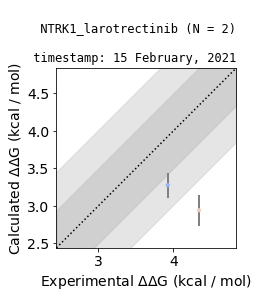

In [96]:
make_plot(
    dataframe=test_laro_df,
    target_name="NTRK1_larotrectinib",
    extra_name='flat',
    title=''
     )

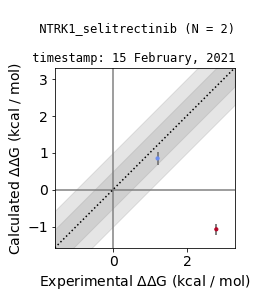

In [97]:
make_plot(
    dataframe=test_seli_df,
    target_name="NTRK1_selitrectinib",
    extra_name='flat',
    title=''
     )

In [98]:
test_laro_df

,DDG (kcal / mol),dDDG (kcal / mol),exp_DDG (kcal / mol),|DDG - exp_DDG|
G595R,2.940891,0.209595,4.339467,1.398576
G667C,3.274591,0.164289,3.923073,0.648482


In [99]:
test_seli_df

,DDG (kcal / mol),dDDG (kcal / mol),exp_DDG (kcal / mol),|DDG - exp_DDG|
G595R,0.842457,0.178887,1.203973,0.361516
G667C,-1.075160,0.154937,2.793208,3.868368
